**Завдання:**

1. Використовуючи датасет за файлу **trayn.csv**, побудуйте діаграми розподілу для значень з поля **"Age"**.
2. Заповніть пропущені значення в датасеті з файлу **train.csv**.
3. Обгрунтуйте вибір способу заповнення пропущенних значень.

**1. Завантаження та вивід частини датасету.**

In [133]:
import pandas as pd

df = pd.read_csv('trayn.csv')
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


Аналізуючи даний датасет можна зробити висновок у доцільності заповнення пропущених даних лише колонки **'Age'** та недоцільності обробки колонки **'Cabin'**, у зв'язку з тим, що номера каюти відсутні у всіх пасажирів третього класу, та у неможливості конструктивно використовувати дану інформацію.

**2. Відображення діаграми розподілу даних колонки "Age".**

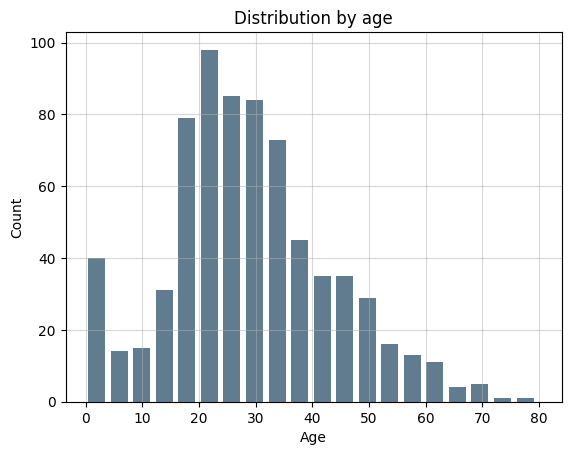

In [134]:
import matplotlib.pyplot as plt
import numpy as np

plt.hist(df["Age"], 20, color = '#607c8e', width=3 )
plt.title("Distribution by age")
plt.xlabel("Age")
plt.ylabel("Count")
plt.grid(axis='x', alpha=0.5)
plt.grid(axis='y', alpha=0.5)

plt.show()

В результаті бачимо нормальний розподіл зі зміщенням вліво. Прирістом кількості пасажирів віком до 5 років, думаю можна знехтувати. Заповнити пропущенні значення можна кількома способами:

1. Заповнити медіанним значенням або середнім значенням при обрізці правої частини діаграми (приблизно на 25%). Досить простий метод буду використовувати, якщо кількість пропущених значень не перевищує 5 відсотків від загальної кількості.

2. Рандомне значення віку з вірогідністю визначеною за законом розподілу даної діаграми. Є сенс використовувати при досить великій кількості пропущених даних.

**3. Відобразимо відсоткову частку пропущених даних.**

In [135]:
count_nan = df['Age'].isna().sum()

print(f"Кількість пропусків дорівнює {count_nan}, що становить {round(100*count_nan/len(df['Age']), 2)} процентів від загальної кількості даних.")

Кількість пропусків дорівнює 177, що становить 19.87 процентів від загальної кількості даних.


**4. Заповнимо пропущені дані рандомними значеннями згідно ваги колонок гістограми.**

In [136]:
hist, bin_edges = np.histogram(df['Age'].dropna(), bins=20)
hist = hist / hist.sum()
bin_edges = [round(x) for x in bin_edges]
bin_edges[0] = 1

df['Age'].fillna(pd.Series(np.random.choice(bin_edges[:-1], size=len(df['Age']), p=hist)), inplace=True)
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,16.0,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


**5. Відобразимо діаграму віку пасажирів з доповненими даними колонки.**

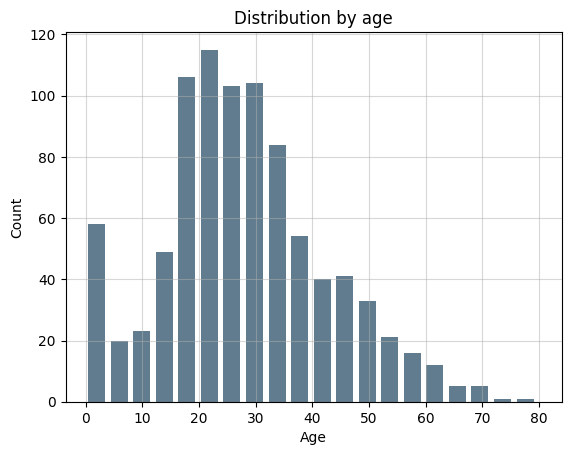

In [137]:
plt.hist(df["Age"], 20, color = '#607c8e', width=3 )
plt.title("Distribution by age")
plt.xlabel("Age")
plt.ylabel("Count")
plt.grid(axis='x', alpha=0.5)
plt.grid(axis='y', alpha=0.5)

plt.show()

**Висновок:**

Як бачимо, форма гістограми зберігла свою форму та пропорцію, чого не відбулося б після доповнення лише середнім або медіанним значенням даних, що досліджуються.